In [2]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image
import argparse
import os
import random
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import ImageFolder
from torch.optim import Adam
import glob
import json

In [3]:
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def save_checkpoint(g_model, d_model, optimizer_g, optimizer_d, trial_hyperparams):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint.pt")
    torch.save({
        'generator_state_dict': g_model.state_dict(),
        'discriminator_state_dict': d_model.state_dict(),
        'optimizer_g_state_dict': optimizer_g.state_dict(),
        'optimizer_d_state_dict': optimizer_d.state_dict(),
        'trial_hyperparams' : trial_hyperparams
    }, checkpoint_path)

def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator_state_dict = checkpoint['generator_state_dict']
    discriminator_state_dict = checkpoint['discriminator_state_dict']
    optimizer_g_state_dict = checkpoint['optimizer_g_state_dict']
    optimizer_d_state_dict = checkpoint['optimizer_d_state_dict']
    trial_hyperparams = checkpoint.get('trial_hyperparams', None)
    
    return trial_hyperparams, generator_state_dict, discriminator_state_dict, optimizer_g_state_dict, optimizer_d_state_dict
    

def find_latest_checkpoint():
    checkpoints = glob.glob(os.path.join(checkpoint_dir, "checkpoint_epoch_*.pt"))
    if checkpoints: 
        # Use the OS metadata to recognize the latest file changed/added
        latest_checkpoint = max(checkpoints, key = os.path.getctime)
        return latest_checkpoint
    else: 
        return None

In [4]:
# Root directory for dataset
root_dir = r''
# r'/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/Splitted data by era - GAN project/test_iron'

# Number of workers for dataloader. (4 * nr_gpus)
workers = (4 * 1)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

batch_size = 128

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

Device:  cuda:0


In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

dataset = ImageFolder(root = root_dir, transform = transform)

data_loader = DataLoader(dataset, batch_size, shuffle = True, num_workers = workers)

for images, labels in data_loader:
    print(images.shape)  # Print the shape of the images batch
    print(labels)  # Print the labels for the images
    break  # Only print the first batch for demonstration


class_to_idx = dataset.class_to_idx

# Print the mapping of class names to labels
print(class_to_idx)


torch.Size([128, 3, 128, 128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
{'iron': 0}


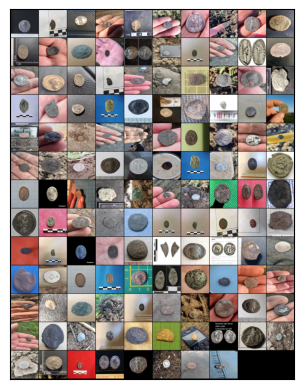

In [6]:
def show_image_grid(images: torch.Tensor, ncol: int): 
    image_grid = make_grid(
        images, 
        ncol
    ) # Make images into a grid 

    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last 
    image_grid = image_grid.cpu().numpy() 

    plt.imshow(image_grid)
    plt.xticks([]) # Empty x and y labels 
    plt.yticks([])
    plt.show() 


show_image_grid(
    images = images, 
    ncol = 10
)

In [7]:
n_channels = 3 # RGB

"""
def calc_output_size(input_size, kernel, padding, stride):
    return (input_size + 2 * padding - kernel // stride) + 1
"""

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # Mean 0, STD 0.2
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class D(nn.Module):
    def __init__(
            self, hyperparams: dict
        ):
        super(D, self).__init__()
        self.ngpu = ngpu
        ndf = hyperparams['ndf']
        self.main = nn.Sequential(
            # Input is (n_channels) x 128 x 128
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x) # Output size = 1x1 
        return x 



class G(nn.Module):
    def __init__(
        self,
        hyperparams: dict
    ): 
        super(G, self).__init__()

        self.ngpu = ngpu

        latent_size = hyperparams['nz']
        num_feature_maps = hyperparams['ngf']
        
        self.layers = nn.ModuleList() 
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_size, num_feature_maps * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 8),
            nn.ReLU(inplace=True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(num_feature_maps * 8, num_feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(inplace=True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(inplace=True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(inplace=True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(num_feature_maps, n_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            # state size. ``(nc) x 64 x 64``
            # Adding one more layer to upscale from 64x64 to 128x128
            nn.ConvTranspose2d(n_channels, n_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 128 x 128``
        )        

    def forward(self, x):
        x = self.main(x) # Output size = 64x64 
        return x 


In [35]:
# Init parameters 
# Checkpoint docs: https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
# AAU Slurm Requeue: https://aicloud-docs.claaudia.aau.dk/slurm/

max_trials = 50
curr_trials = 0
real_label = 1 
fake_label = 0 
# Checkpoint vars
start_epoch = 0
latest_checkpoint = None
g_state_dict = None
d_state_dict = None
optimizer_g_state_dict = None
optimizer_d_state_dict = None
trial_hyperparams = None

img_list = []
epoch_mean_losses_G = []
epoch_mean_losses_D = []

criterion = nn.BCELoss()

# Main folder to store the experiments in 
main_folder = "GAN_RANDOM_SEARCH_IRON"

hyperparameters_G = {
    'nz': [50, 100, 150, 200],  # Size of latent space vector 
    'lr': [round(i * 0.0001, 10) for i in range(1, 100)],  # Between 0.0001 and 0.0999
    'ngf': random.randint(32, 128)
}

hyperparameters_D = {
    'ndf': random.randint(32, 128),  # Number of feature maps in discriminator
    'lr': [round(i * 0.0001, 15) for i in range(1, 100)],
}

general_hyperparameters = {
    'batch_size': [32, 64, 128, 256],
    'num_epochs': [30, 50, 75, 100],
    'image_size': 128 # Image size NxN
}    

# Check if there exists a checkpoints before starting - Load once
latest_checkpoint = find_latest_checkpoint()
if latest_checkpoint:
    trial_hyperparams_load, g_state_dict_load, d_state_dict_load, optimizer_g_state_dict_load, optimizer_d_state_dict_load = load_checkpoint(latest_checkpoint)
    optimizer_d_state_dict = optimizer_d_state_dict_load
    optimizer_g_state_dict = optimizer_g_state_dict_load
    g_state_dict = g_state_dict_load
    d_state_dict = d_state_dict_load
    trial_hyperparams = trial_hyperparams_load

# Create or load the losses.txt for epochs over a trial
if not os.path.exists(os.path.join(main_folder, 'current_trial.txt')):
    with open(os.path.join(main_folder, 'current_trial.txt'), 'w') as f:
        f.write("0")
else: 
    with open(os.path.join(main_folder, 'current_trial.txt'), 'r') as f:
        line = f.readlines() 
        curr_trials = int(line[-1])

# Start random search trials
while (curr_trials <= max_trials):
    # Trial folder
    trial_dir = os.path.join(main_folder, f"trial_{curr_trials}")
    if not os.path.exists(trial_dir):
        os.makedirs(trial_dir)
    
    losses_file_path = os.path.join(trial_dir, 'losses.txt')
    # Check if the losses file already exists    
    if not os.path.exists(losses_file_path):
        with open(losses_file_path, 'w') as f:
            f.write("")
    else: 
        with open(losses_file_path, 'r') as f:
            lines = f.readlines() 
            # Update current epoch
            if lines:
                last_line = lines[-1]
                parts = last_line.split(' - ')
                start_epoch = int(parts[0])
            
    try:
        if latest_checkpoint: 
            sampled_hyperparams_general = trial_hyperparams['general']
            sampled_hyperparams_D = trial_hyperparams['discriminator']
            sampled_hyperparams_G = trial_hyperparams['generator']
        else: 
            sampled_hyperparams_general = {
                'batch_size': random.choice(general_hyperparameters['batch_size']),
                'num_epochs': random.choice(general_hyperparameters['num_epochs']),
            }
            sampled_hyperparams_D = {
                'ndf': hyperparameters_D['ndf'], 
                'lr': random.choice(hyperparameters_D['lr']),              
            }
        
            sampled_hyperparams_G = {
                'nz': random.choice(hyperparameters_G['nz']),
                'ngf': hyperparameters_G['ngf'], 
                'lr': random.choice(hyperparameters_G['lr'])
            }
            
            num_epochs = sampled_hyperparams_general['num_epochs']
            batch_size = sampled_hyperparams_general['batch_size']


        # Save sampled hyperparameters for this trial
        trial_hyperparams = {
            'general': sampled_hyperparams_general,
            'discriminator': sampled_hyperparams_D,
            'generator': sampled_hyperparams_G
        }
        
        # Fresh dataloader
        data_loader_rs = DataLoader(
            dataset, # Resized to global image_size 
            sampled_hyperparams_general['batch_size'], 
            shuffle = True,
            num_workers = workers # Parallel workers
        )    

        # Used for showing the progression of G
        # Number of fake images made is 64
        fixed_noise = torch.randn(64, sampled_hyperparams_G['nz'], 1, 1, device = device) 
        
        # Init models
        d_model = D(sampled_hyperparams_D).to(device) 
        g_model = G(hyperparams = sampled_hyperparams_G).to(device)

        if not latest_checkpoint:
            # Initialize model weights - Checkpoints save internal states 
            g_model.apply(weights_init)
            d_model.apply(weights_init)

            with open(os.path.join(trial_dir, "hyperparameters.txt"), "w") as f:
                f.write("Hyperparameters:\n")
                for key, value in trial_hyperparams.items():
                    f.write(f"{key}:\n")
                    for param, val in value.items():
                        f.write(f"{param}: {val}\n")

        if g_state_dict:
            g_model.load_state_dict(g_state_dict)
            # Reset
            g_state_dict = None
        if d_state_dict:
            d_model.load_state_dict(d_state_dict)
            # Reset 
            d_state_dict = None
    
        # Handle multi-GPU if desired
        if (device.type == 'cuda') and (ngpu > 1):
            g_model = nn.DataParallel(g_model, list(range(ngpu)))
        if (device.type == 'cuda') and (ngpu > 1):
            d_model = nn.DataParallel(d_model, list(range(ngpu)))
    
        optimizer_d = Adam(d_model.parameters(), lr = sampled_hyperparams_D['lr'], betas = (0.5, 0.999))
        optimizer_g = Adam(g_model.parameters(), lr = sampled_hyperparams_G['lr'], betas = (0.5, 0.999))

        if optimizer_g_state_dict:
            optimizer_g.load_state_dict(optimizer_g_state_dict)
            # Reset
            optimizer_g_state_dict = None
        if optimizer_d_state_dict:
            optimizer_d.load_state_dict(optimizer_d_state_dict)
            # Reset 
            optimizer_d_state_dict = None

        # Mean loss for epochs init- Reset
        if not latest_checkpoint:
            epoch_mean_losses_G = []
            epoch_mean_losses_D = []

        # If checkpoints was found - Reset
        if latest_checkpoint: 
            # Reset - No need to check again
            latest_checkpoint = None

        # EPOCHS RUN
        for epoch in range(start_epoch, num_epochs):
            # Debug
            # print("START EPOCH", start_epoch)
            # print("Current epoch", epoch)
            # print("TO EPOCH", num_epochs)
            # print("Current trial", curr_trials)
            
            D_losses = []
            G_losses = []
            img_list = []
            avg_loss_G = 0.
            avg_loss_D = 0.
            
            # Epoch folder
            epoch_dir = os.path.join(trial_dir, f"epoch_{epoch}")
            if not os.path.exists(epoch_dir):
                os.makedirs(epoch_dir)

            if epoch % 5 == 0: # Save for every 5 epoch
                # DEBUG
                # print("EPOCH % 5 == 0 called")
                # print("CURRENT EPOCH", epoch)
                save_checkpoint(
                    g_model = g_model, 
                    d_model = d_model, 
                    optimizer_g = optimizer_g, 
                    optimizer_d = optimizer_d,
                    trial_hyperparams = trial_hyperparams
                )

            # Epoch iterations 
            for i, data in enumerate(data_loader_rs, 0):                
                # Train discriminator with real images
                d_model.zero_grad()
                real_device = data[0].to(device) # Use the imported data 
                b_size = real_device.size(0) # Real batch size 
                label = torch.full((b_size,), real_label, dtype = torch.float, device = device) # Fill the batch with real_labels i.e. 1
                # Forward 
                output = d_model(real_device).view(-1)
                
                errD_real = criterion(output, label)
                errD_real.backward()
                D_x = output.mean().item() # Mean loss from D model for each batch
    
                # Train discriminator with fake images 
                latent = torch.randn(b_size, sampled_hyperparams_G['nz'], 1, 1, device = device) # Create the latent vector with count(b_size) and dynamic size  
                fake = g_model(latent) # Feed latent vector sample to generator 
                label.fill_(fake_label) # Replace all labels with fake label
                output = d_model(fake.detach()).view(-1) # Feed and forget the fake image (detach) from the computational tree then Flatten output 
                errD_fake = criterion(output, label)
                errD_fake.backward() 
                D_G_z1 = output.mean().item() # The output loss from the discriminator based on fake images made by the generator (D_G_z1 -> D(G(z1))) - The mean across the batch
                errD = errD_real + errD_fake # Compute the total error for the discriminator over real and fake runs 
                optimizer_d.step()
    
                # Train the generator 
                g_model.zero_grad() 
                label.fill_(real_label) # fake labels are real for generator cost
                output = d_model(fake).view(-1) # Since we just updated D, perform another forward pass of all-fake batch through D (d_model)
                errG = criterion(output, label) # Calculate G's loss based on this output
                errG.backward()
                D_G_z2 = output.mean().item() # Same as (D_G_z1 -> D(G(z1))) - The output loss on fake images made by the generator. Training
                optimizer_g.step()
                
                G_losses.append(errG.item())
                D_losses.append(errD.item())
                
                if (i == len(data_loader_rs) - 1):
                    with torch.no_grad():
                        # Number of fake images generated depends on the fixed noise vector
                        fake = g_model(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))

            # Calculate mean loss for the epoch
            avg_loss_G_epoch = np.mean(G_losses)
            avg_loss_D_epoch = np.mean(D_losses)

            # Save losses to a file
            with open(os.path.join(trial_dir, 'losses.txt'), 'a') as f:
                f.write(f"{epoch} - {avg_loss_G_epoch} : {avg_loss_D_epoch}\n")

            for i, img_grid in enumerate(img_list):
                filename = os.path.join(epoch_dir, f'generated_images_epoch_{i}.png')
                vutils.save_image(img_grid, filename)   

        # Plot and save the losses graph
        epochs = []
        generator_losses = []
        discriminator_losses = []
        with open(os.path.join(trial_dir, 'losses.txt'), 'r') as file:
            lines = file.readlines()
            for line in lines: 
                parts = line.strip().split(' - ')
                epoch = int(parts[0])
                losses = parts[1].split(' : ')
                generator_loss = float(losses[0])
                discriminator_loss = float(losses[1])
    
                epochs.append(epoch)
                generator_losses.append(generator_loss)
                discriminator_losses.append(discriminator_loss)

        # Save the current trial
        curr_trials += 1 
        with open(os.path.join(main_folder, 'current_trial.txt'), 'w') as f:
            f.write(str(curr_trials))
            
        # Plot and save the losses graph
        plt.figure(figsize = (10, 5))
        plt.plot(epochs, generator_losses, label = 'Generator Loss')
        plt.plot(epochs, discriminator_losses, label = 'Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Generator and Discriminator Losses across Epochs')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(trial_dir, 'epoch_losses_graph.png'))
        plt.show()

    # Errors should not affect the number of trials
    except Exception as e: 
        raise Exception(f"EXCEPTION: An error occurred during trial {curr_trials}: {e}")
    finally: 
        start_epoch = 0


START EPOCH 4
Current epoch 4
TO EPOCH 11
Current trial 1
START EPOCH 4
Current epoch 5
TO EPOCH 11
Current trial 1
EPOCH % 5 == 0 called
CURRENT EPOCH 5
SAVING CHECKPOINT
DONE SAVING CHECKPOINT


KeyboardInterrupt: 